### **使用Black-Scholes模型直接计算**
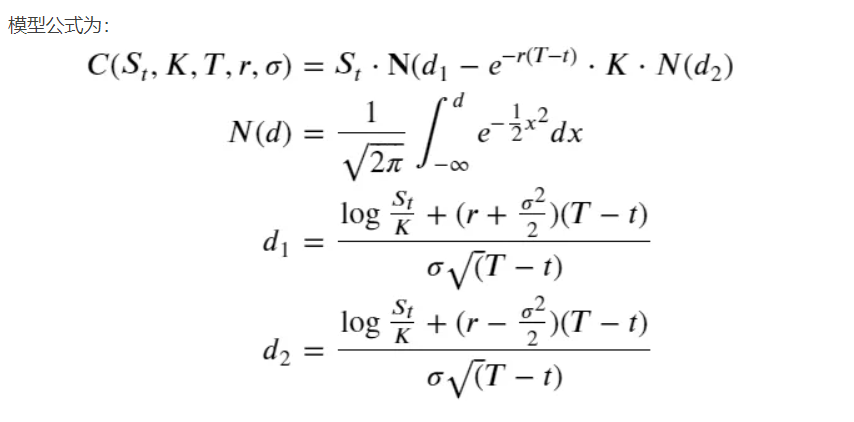

其中，St、K、T、r、σ分别为标的资产价格、执行价格、期限、无风险利率和波动率。根据上述公式和已知参数可以很容易计算普通欧式期权的价格。

In [2]:
# 基于Black-Scholes 公式的期权定价
from math import log,sqrt,exp
from scipy.stats import norm

In [3]:
def BSM(S,K,T,r,sigma):
    d1 = (log(S/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    Callprice = S * norm.cdf(d1) - K * exp(-r*T) * norm.cdf(d2)    # Putprice = K * exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    print('看涨期权价格：%.4f' % Callprice)    #print('看跌期权价格：%.4f' % Putprice)
    
# 参数
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
BSM(S,K,T,r,sigma)

看涨期权价格：10.4506


### **使用QuantLib进行计算**

In [5]:
import QuantLib as ql

# 设定全局估值日
today = ql.Date(18,11,2020)
ql.Settings.instance().evaluationDate = today

# 构建期权
# 普通看涨期权
payoff = ql.PlainVanillaPayoff(ql.Option.Call, 100)

# 到期日期
europeanExercise = ql.EuropeanExercise(ql.Date(18,11,2021))
option = ql.EuropeanOption(payoff, europeanExercise)

# 输入参数--标的资产价格，无风险利率，标的资产波动率
u = ql.SimpleQuote(100)    # 标的资产价值
r = ql.SimpleQuote(0.05)    # 无风险利率
sigma = ql.SimpleQuote(0.2)    # 波动率

# 假定无风险利率和波动率曲线是平的
riskFreeCurve = ql.FlatForward(0,ql.TARGET(),ql.QuoteHandle(r),ql.Actual360())
volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual360())

#初始化BS过程，并构造engine
process = ql.BlackScholesProcess(ql.QuoteHandle(u),
                              ql.YieldTermStructureHandle(riskFreeCurve),
                              ql.BlackVolTermStructureHandle(volatility))
engine = ql.AnalyticEuropeanEngine(process)
#对期权设定该engine
option.setPricingEngine(engine)
print(f'看涨期权的当前价值为：{option.NPV():.4f}')

看涨期权的当前价值为：10.5395


**得到的结果与上面直接使用BS公式计算结果基本上一致，当然QuantLib的过程也是更加复杂和繁琐，而且无法看到背后计算的逻辑（公式）。QuantLib构建完Instruments（这里是期权option）和设置定价引擎（Prcing Engines）后，除了可以获取价格（NPV），还有很多扩展功能，包括计算期权的希腊字母（即期权价格关于标的价格、时间、波动率等的变化率衡量指标）。**

In [6]:
#计算期权的希腊字母
print("%-12s: %4.4f" %("Delta", option.delta()))
print("%-12s: %4.4f" %("Gamma", option.gamma()))
print("%-12s: %4.4f" %("Theta", option.vega()))

Delta       : 0.6377
Gamma       : 0.0186
Theta       : 37.7516


**如果对上面一些参数(如标的资产价值，无风险利率等)做出修改，engine会自动重新计算期权的价值**

In [7]:
#如果当前标的资产的价值为105
#以看涨期权为例
payoff = ql.PlainVanillaPayoff(ql.Option.Call, 100.0)
option = ql.EuropeanOption(payoff, europeanExercise)
option.setPricingEngine(engine)
u.setValue(105.0)
print(f'看涨期权的当前价值为：{option.NPV():.4f}')

看涨期权的当前价值为：13.9496


In [8]:
#也可以同时改变多个参数
u.setValue(98.0)
r.setValue(0.04)
sigma.setValue(0.25)
print(f'看涨期权的当前价值为：{option.NPV():.4f}')

看涨期权的当前价值为：10.7357


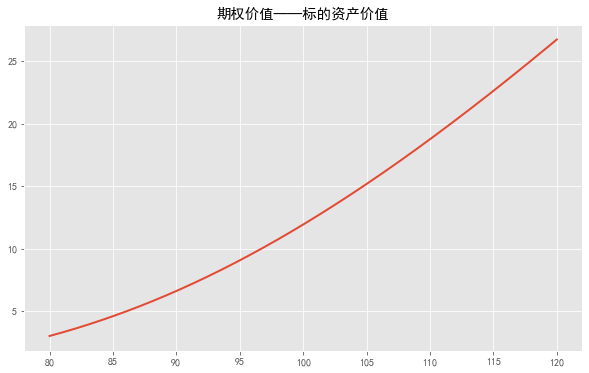

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
plt.style.use('ggplot')
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
#不断改变当前标的资产的价值，可以查看其对期权价值的影响
f, ax = plt.subplots(figsize=(10,6))
X = np.linspace(80.0, 120.0, 400)
cv = []
for i in X:
    u.setValue(i)
    cv.append(option.NPV())
ax.set_title('期权价值——标的资产价值')
_ = ax.plot(X, cv,linewidth=2)
plt.show()

In [10]:
#修改估值日期
ql.Settings.instance().evaluationDate = ql.Date(18, 6, 2021)
print(f'看涨期权的当前价值为：{option.NPV():.4f}')

看涨期权的当前价值为：22.6307


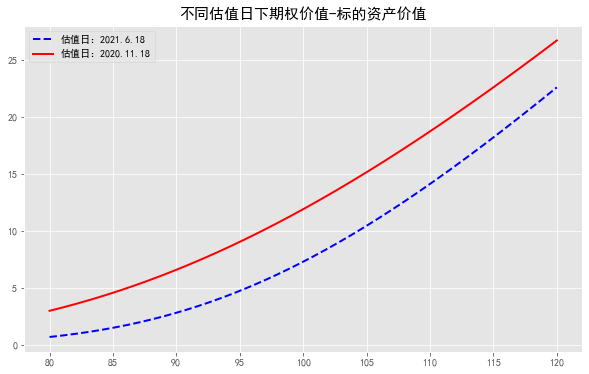

In [11]:
#不同估值日期对比
y = []
for i in X:
    u.setValue(i)
    y.append(option.NPV())
plt.figure(figsize=(10,6))
plt.plot(X, y, '--',linewidth=2,color='b',label='估值日：2021.6.18')
plt.plot(X,cv,linewidth=2,color='r',label='估值日：2020.11.18')
plt.legend()
plt.title('不同估值日下期权价值-标的资产价值',size=15)
plt.show()

图中显示，对于同一个到期日的欧式期权（2021年11月18日到期），站在2021年6月18日进行估值，相比于2020年11月18日，期权价值是整体下降的。从上述分析可知，在计算期权价格时，直接使用BS公式可以简洁的得出结果，而QuantLib的定价引擎就像个黑箱子，但是其扩展功能较多，可以通过改变定价方法、相关参数等快速对期权进行重新定价。